<a href="https://colab.research.google.com/github/johsieders/fttai/blob/main/src/cola/colaB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from https://mccormickml.com/2019/07/22/BERT-fine-tuning
# The Corpus of Linguistic Acceptability (CoLA)

# Johannes Siedersleben
# QAware GmbH, Munich
# 28.2.2021

In [2]:
# uncomment this if import fails
# !pip install transformers

# Python imports
import random
import pickle
from collections.abc import Callable
from time import perf_counter

# utilities for download and file import
import pandas as pd

# neural metworks support: torch, Hugging Face transformers
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, AdamW

# local imports
from download import download
from logger import Logger
from showResults import showConfusionMatrix, showMetrics, showProgress

In [ ]:
class Learner(object):
    def __init__(self, module: nn.Module,
                 optimizer: torch.optim.Optimizer,
                 loss_fct: Callable,
                 device: torch.device):
        self.module = module
        self.optimizer = optimizer
        self.loss_fct = loss_fct
        self.device = device

    def train(self, dataloader: DataLoader, logger: Logger) -> None:
        """
        @param dataloader: a dataloader with input_ids at 0, labels at 1
        @param logger: a logger
        @return: None
        This is one epoch, the essential loop of artificial intelligence.
        It runs over all training sentences, one minibatch at a time.
        One loop takes about 2 seconds on a i7 cpu!
        """
        self.module.train()

        for batch in dataloader:
            vectors, labels = batch
            labels = labels.view(-1, 1)
            logits = self.module(vectors)
            loss = self.loss_fct(logits, labels)
            logger.log(loss.item())
            loss.backward()  # compute gradient
            clip_grad_norm_(module.parameters(), 1.0)  # normalize gradient
            self.optimizer.step()  # do one optimization step
            self.optimizer.zero_grad()  # reset gradient

    def predict(self, dataloader: DataLoader) -> tuple:
        """
        @param dataloader: a dataloader with input_ids at 0, labels at 2
        @return: tuple of (label, prediction), two tensors
        """
        self.module.eval()
        targets = torch.tensor((), dtype=torch.int, device=self.device)
        predictions = torch.tensor((), dtype=torch.int, device=self.device)

        for batch in dataloader:
            vectors, labels = batch
            with torch.no_grad():
                logits = self.module(vectors)
            preds = torch.argmax(logits, dim=1)
            targets = torch.cat((targets, labels))    # collect targets
            predictions = torch.cat((predictions, preds))  # collect predictions

        return targets, predictions

    def fit(self, dataloader: DataLoader, n_epochs: int) -> list:
        """
        @param dataloader: a dataloader with input_ids at 0, attention_mask at 1, labels at 2
        @param n_epochs: number of epochs
        @return: the protocol
        """
        logger = Logger()
        for i in range(n_epochs):
            logger.log(f'epoch {i}')
            self.train(dataloader, logger)
        return logger.getProtocol()

In [ ]:
def getDevice(cuda_desired: bool) -> torch.device:
    """
    @param cuda_desired: True if cuda desired
    @return: cuda if desired and available, cpu otherwise
    """
    return torch.device('cuda') if cuda_desired and torch.cuda.is_available() \
        else torch.device('cpu')

In [ ]:
def readData(filename: str,
                        n_sentences: int,
                        col_sentence: int,
                        col_label: int,
                        delimiter: str = '\t') -> tuple:
    """
    @param filename: file to be read from
    @param n_sentences: number of sentences to be read
    @param delimiter: a delimiter
    @param col_sentence: index of column of sentences
    @param col_label: index of column of labels
    @return: a tuple containing a list of sentences and a list of labels
    """
    df = pd.read_csv(filename, delimiter=delimiter, nrows=n_sentences, header=None)
    return df[col_sentence].values.tolist(), df[col_label].values.tolist()

In [ ]:
def getTokenizer(device: torch.device) -> Callable:

    bert_model = BertModel.from_pretrained(
        "bert-base-uncased",  # Use the 12-layer BERT module, with an uncased vocab.
        output_hidden_states=True,  # return hidden-states.
    )
    if device == torch.device('cpu'):
        bert_model.cpu()
    else:
        bert_model.cuda()

    bert_model.eval()

    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    def tokenize(sentences: list, max_length: int) -> Tensor:
        vectors = []

        for s in sentences:
            dict = bert_tokenizer(s,
                             add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                             truncation=True,
                             max_length=max_length,
                             pad_to_max_length=True,
                             return_attention_mask=True,
                            )

            toks = dict['input_ids']
            attn = dict['attention_mask']
            token_ids = torch.tensor(toks, device=device).view((1, -1))
            attn_mask = torch.tensor(attn, device=device).view((1, -1))

            with torch.no_grad():
                output = bert_model(token_ids, attn_mask)

            hidden_states = output[2]
            token_vectors = hidden_states[-2][0]  # shape = (#tokens, 768)
            # result[i] = average token_vecs[i, j], j = 0 .. 767
            vector = torch.mean(token_vectors, dim=0)  # shape = (768)
            vectors.append(vector)

        vectors = torch.cat(vectors).view(len(sentences), -1)
        return vectors

    return tokenize


In [ ]:
def getDataloader(token_ids: Tensor,
                  labels: Tensor,
                  split_factor: float,
                  batch_size: int) -> tuple:
    """
    @param token_ids: token_ids, plain Python list, (n_sentences x max_length)
    @param labels: labels, plain Python list (len = n_sentences)
    @param split_factor: share of training sentences
    @param batch_size: size of minibatch
    @return: tuple of two dataloaders, one for training and one for test

    Dataloaders return on each call a list of k 3-tupels (token_ids, attention_mask, label);
    with k = batch_size. All returned elements are torch.tensors on the requested device
    """

    dataset = TensorDataset(token_ids, labels)
    train_size = int(split_factor * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_dataloader = DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=batch_size
    )

    test_dataloader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size
    )

    return train_dataloader, test_dataloader

In [ ]:
def getModule(device: torch.device) -> nn.Module:
    module = nn.Linear(768, 1)
    if device == torch.device('cpu'):
        module.cpu()
    else:
        module.cuda()
    return module

In [ ]:
def getOptimizer(module: nn.Module,
                 lr: float,
                 eps: float) -> torch.optim.Optimizer:
    """
    @param module: a module
    @param lr: learning rate
    @param eps: stop criterion
    @return: the Adam optimizer (any other choice is valid)
    """
    return AdamW(module.parameters(), lr=lr, eps=eps)

In [ ]:
def getLossFunction() -> Callable:
    """
    @return: binary cross entropy loss (or any other loss function)
    """
    return nn.BCEWithLogitsLoss()

### Define the configuration and put it in a dictionary

In [ ]:
seed = 42
batch_size = 8
n_sentences = 100
max_length = 64
split_factor = 0.8
cuda_desired = False
lr = 3e-5
eps = 1e-8
n_epochs = 4

cfg = {'seed': seed,
   'batch_size': batch_size,
   'n_sentences': n_sentences,      # number of sentences to read
   'max_length': max_length,        # max length of sentence (guess or find out)
   'split_factor': split_factor,    # share of training sentences
   'cuda_desired': cuda_desired,    # True if cuda desired
   'lr': lr,                        # learning rate of optimizer
   'eps': eps,                      # stop criterion of optimizer
   'n_epochs': n_epochs}

### Set the seeds and determine device

In [ ]:
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = getDevice(cuda_desired)

### Download and unzip

In [ ]:
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
zipped_file = 'cola_public_1.1.zip'
zipped_dir = './cola_public_1.1/'
unzipped_file = './cola_public/raw/in_domain_train.tsv'
download(url, zipped_file, zipped_dir, unzipped_file)

### Read the data

In [ ]:
col_sentence = 3  # index of column of sentences
col_label = 1  # index of column of labels
sentences, labels = readData(unzipped_file, n_sentences, col_sentence, col_label)

### Compute token_ids

In [ ]:

t0 = perf_counter()
tokenizer = getTokenizer(device)
token_ids = tokenizer(sentences, max_length)
labels = torch.tensor(labels, dtype=torch.float32, device=device)

t1 = perf_counter()
print(f'elapsed time for tokenizing: {t1 - t0:.4f}')

### Define the algorithm

In [ ]:
train_dataloader, test_dataloader = getDataloader(token_ids, labels, split_factor, batch_size)
module = getModule(device)     # Linear(768, 1)
optimizer = getOptimizer(module, lr, eps)
loss_fct = getLossFunction()
learner = Learner(module, optimizer, loss_fct, device)

### Get going

In [ ]:
t0 = perf_counter()
protocol = learner.fit(train_dataloader, n_epochs)
t1 = perf_counter()
print(f'\nelapsed time for training: {t1 - t0:.4f}')

### Make predictions on train and test data

In [ ]:
train_labels, train_predictions = learner.predict(train_dataloader)
test_labels, test_predictions = learner.predict(test_dataloader)

### Save results

In [ ]:
log_object = (cfg,
              protocol,
              train_labels, train_predictions,
              test_labels, test_predictions)

log_file = 'log_000.pickle'
with open(log_file, 'wb') as log:
    pickle.dump(log_object, log)

### Show progress


elapsed time = 0.0458

total number of train labels:          80
total number of correct train labels:  59


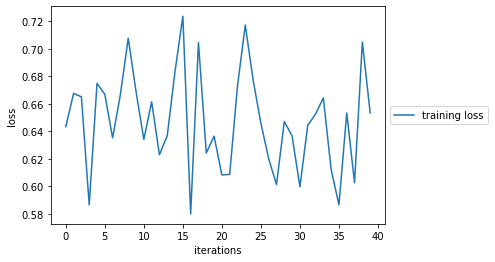

In [3]:
log_file = 'log_000.pickle'
with open(log_file, 'rb') as log:
    log_object = pickle.load(log)

cfg, protocol, \
train_labels, train_predictions, \
test_labels, test_predictions = log_object

elapsed_time = protocol[-1][0] - protocol[0][0]
print(f'\nelapsed time = {elapsed_time:.4f}')

# show the outcome
print(f"\n{'total number of train labels:':38} {len(train_labels)}\n"
      f"{'total number of correct train labels:':38} {len(train_labels[train_labels == 1])}")

showProgress(protocol)

### Show metrics and confusion matrices

In [ ]:
print('\nresult on train data')
showMetrics(train_labels, train_predictions)
print('\nresult on test data')
showMetrics(test_labels, test_predictions)

cat_names = ['incorrect', 'correct']
print('\nresult on test data')
showConfusionMatrix(train_labels, train_predictions, cat_names)
print('\nresult on test data')
showConfusionMatrix(test_labels, test_predictions, cat_names)